# Hair Segmentation 

In [15]:
import os
import numpy as np
import torch
import torch.utils.data as td
from PIL import Image
import matplotlib.pyplot as plt
import math
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
#print(device)
device = 'cpu'

## Import dataset

In [16]:
# Dataset class
class HairDataset(td.Dataset):
    
    #mode should be 'Training' or 'Testing'
    def __init__(self, img_dir, gt_dir, mode='Training', image_size=(224, 224)):
        super(HairDataset, self).__init__()
        self.mode = mode
        self.image_size = image_size
        self.images_dir = os.path.join(img_dir, mode)
        self.images = sorted(os.listdir(self.images_dir))
        self.targets_dir = os.path.join(gt_dir, mode)
        self.targets = sorted(os.listdir(self.targets_dir))        
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])    
        img = np.asarray(Image.open(img_path).resize(self.image_size).convert('RGB'))
        target_path = os.path.join(self.targets_dir, self.targets[idx])    
        target = np.asarray(Image.open(target_path).resize(self.image_size).convert('RGB'))
        return img, target

Nombre d'images dans le training set : 840
Nombre d'images dans le testing set : 210


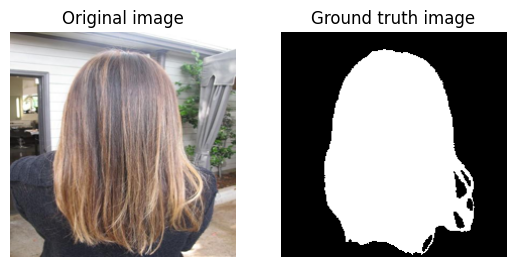

In [17]:
# define dataset dir path
img_dir = '/home/ndo001/Courses/project/hair-seg-project/Figaro1k/Original'
gt_dir = '/home/ndo001/Courses/project/hair-seg-project/Figaro1k/GT'

# build training and testing set
train_set =  HairDataset(img_dir=img_dir, gt_dir=gt_dir, mode='Training')
test_set =  HairDataset(img_dir=img_dir, gt_dir=gt_dir, mode='Testing')
print("Nombre d'images dans le training set :", len(train_set))
print("Nombre d'images dans le testing set :", len(test_set))
X_train = np.array([train_set[i][0] for i in range(len(train_set))])
y_train = np.array([train_set[i][1] for i in range(len(train_set))])
X_test = np.array([test_set[i][0] for i in range(len(test_set))])
y_test = np.array([test_set[i][1] for i in range(len(test_set))])


# visualize images
def visualize_data(images, axes):
    img, target = images[0], images[1]
    axes[0].imshow(img)
    axes[0].set_title('Original image')
    axes[0].axis('off')
    axes[1].imshow(target)
    axes[1].set_title('Ground truth image')
    axes[1].axis('off')

fig, axes = plt.subplots(ncols=2)
visualize_data(train_set[5], axes)


## Create CNN

In [18]:

# Code from https://www.kaggle.com/code/rahuldshetty/hair-segmentation-using-u-net/notebook
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate, BatchNormalization, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau



In [19]:
inputs = Input((224, 224, 3))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
poo5a = MaxPooling2D(pool_size=(2, 2))(conv5)
conv5a = Conv2D(1024, (3, 3), activation='relu', padding='same')(poo5a)
conv5a = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5a)

In [20]:
up6a = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5a), conv5], axis=3)
conv6a = Conv2D(512, (3, 3), activation='relu', padding='same')(up6a)
conv6a = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6a)
up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
conv10 = Conv2D(3, (3, 3), activation='relu', padding='same')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])
model.compile(optimizer='adam', loss='mse', metrics=['acc'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 224, 224, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_24 (Conv2D)             (None, 224, 224, 32  9248        ['conv2d_23[0][0]']              
                                )                                                           

In [21]:
epochs = 1
history = model.fit(X_train,y_train,validation_split=0.05,epochs=epochs,batch_size=64,)
model.save('model.h5')

13/13 [==============================] - 211s 16s/step - loss: 31125.5391 - acc: 0.4452 - val_loss: 15676.1279 - val_acc: 0.8982


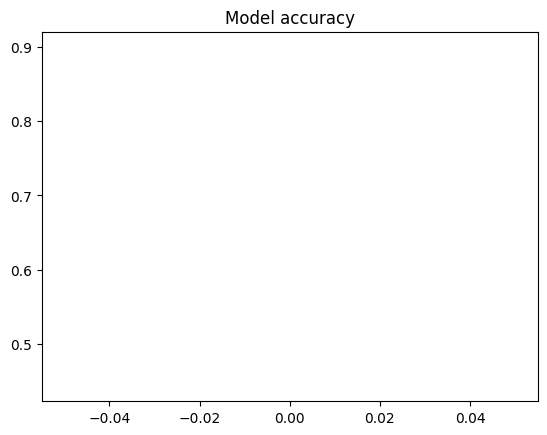

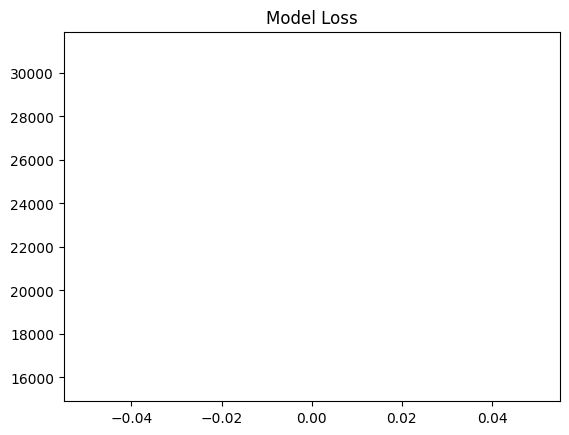

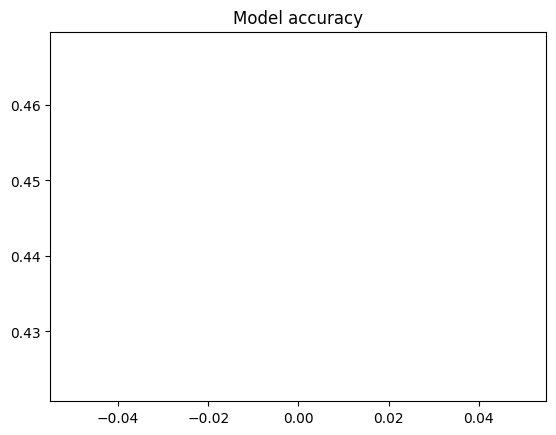

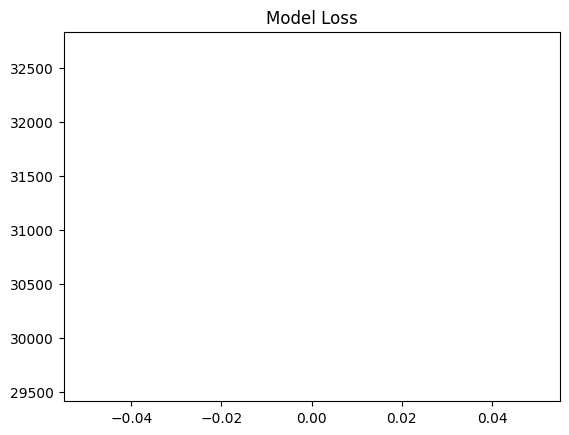

In [22]:
h = history
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.title('Model accuracy')
plt.show()

plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Model Loss')
plt.show()

plt.plot(h.history['acc'])
plt.title('Model accuracy')
plt.show()

plt.plot(h.history['loss'])
plt.title('Model Loss')
plt.show()

7/7 [==============================] - 9s 1s/step
(210, 224, 224, 3)


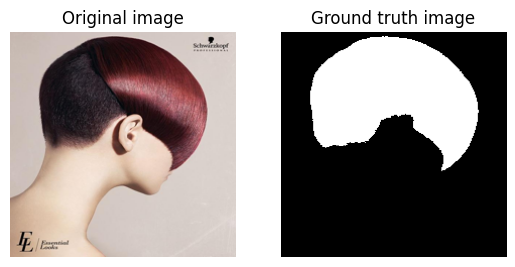

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

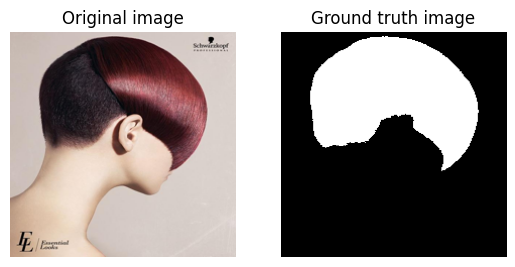

In [23]:
def predict(image):
    return model.predict(image)

idx = 9
fig, axes = plt.subplots(ncols=2)
visualize_data(test_set[idx], axes)

pred = predict(X_test)
print(pred.shape)
plt.show(pred[idx])